# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [2]:
import os

#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import numpy.linalg as LA
import cv2
%matplotlib inline

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    assert initial_img.shape == img.shape, \
        "Unmatch shape"
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Line class and helper functions

In [4]:
def coord2param(line):
    x1,y1,x2,y2 = line
    m = (y2-y1)/(x2-x1+1e-7)
    b = y1 - m*x1
    return (m,b)


def param2coord(param, y_min, y_max):
    m,b = param
    y1 = int(y_min)
    x1 = int((y_min-b)/(m+1e-7))
    y2 = int(y_max)
    x2 = int((y_max-b)/(m+1e-7))
    return (x1,y1,x2,y2)


class Lines:
    """A class to maintain lines"""
    def __init__(self, coords):
        """
        Args
        coords: list of (x1,y1,x2,y2)
        """
        self._num = len(coords)
        if self._num != 0:
            self._lines = np.array(coords)
            self._params = np.zeros((self._num, 2))
            self._lengths = np.zeros(self._num)
            for i in range(self._num):
                x1,y1,x2,y2 = coords[i]
                param = coord2param((x1,y1,x2,y2))
                l = LA.norm(np.array([x1-x2, y1-y2]))
                self._params[i] = param
                self._lengths[i] = l
        else:
            self._lines = None
            self._params = None
            self._lengths = None
        
    @property
    def n_lines(self):
        return self._num

    @property
    def empty(self):
        return self._num == 0
    
    @property
    def coords(self):
        if not self.empty:
            return self._lines.astype(int)
        else:
            return None
    
    @property
    def x_coords(self):
        if not self.empty:
            return self._lines[:, 0::2].flatten()
        else:
            return None
    
    @property
    def y_coords(self):
        if not self.empty:
            return self._lines[:, 1::2].flatten()
        else:
            return None
    
    @property
    def y_min(self):
        if not self.empty:
            return np.min(self.y_coords)
        else:
            return None

    @property
    def y_max(self):
        if not self.empty:
            return np.max(self.y_coords)
        else:
            return None
    
    @property
    def params(self):
        return self._params
    
    @property
    def lengths(self):
        return self._lengths

## More helper function

The above functions can only get you some rough line segments, which may belongs to the edge of two lane lines or other objects. Below are some additional helper functions designed to do the following:
1. Split into two groups according the line segment is on the left/right side of the image.
2. Fit a line according to given line segments endpoints.
3. Apply weighted average to find overall slope and intercept of given line segments.
4. Filter out some orientation of the line segments.

In [5]:
def filter_color(img, low_list, high_list):
    """Filtered out some color in image"""
    assert len(low_list) == len(high_list), \
        "Unmatch number of upper bound and lower bound"
    final_mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for i in range(len(low_list)):
        low = low_list[i]
        high = high_list[i]
        new_mask = cv2.inRange(img, low, high)
        final_mask = cv2.bitwise_or(final_mask, new_mask)
    return cv2.bitwise_and(img, img, mask=final_mask)

def split_lines(lines, w, verbose=False):
    """split lines into left/right group"""
    left_coords = []
    right_coords = []
    for x1,y1,x2,y2 in lines.coords:
        if x1 < w/2 and x2 < w/2:
            left_coords.append([x1,y1,x2,y2])
        elif x1 > w/2 and x2 > w/2:
            right_coords.append([x1,y1,x2,y2])
        else:
            pass # leave the line across middle line out

    n_left = len(left_coords)
    n_right = len(right_coords)
    
    if verbose:
        print("num_left_line: ", n_left)
        print("num_right_line: ", n_right)
        
    left_lines = Lines(left_coords)
    right_lines = Lines(right_coords)
    return (left_lines, right_lines) 
    

def filter_slope(lines, m_min, m_max, verbose=False):
    """filter out slope outside the given range"""
    assert m_min < m_max, \
        "m_min must smaller than m_max"
    
    N = lines.n_lines
    n_valid = 0
    valid_coords = []
    for i in range(N):
        m,b = lines.params[i]
        if m > m_min and m < m_max:
            valid_coords.append(lines.coords[i])
            n_valid += 1
    
    if verbose:
        print("filtered line ratio: {}/{}".format(n_valid, N))
        
    valid_lines = Lines(valid_coords)
    
    return valid_lines


def fit_line(lines):
    """fit a straight line through small line segments"""
    param = np.polyfit(lines.x_coords, lines.y_coords, deg=1)
    return param


def average_slope_intercept(lines):
    """weighted average slope of all line segments"""
    param = np.dot(lines.lengths, lines.params) / (np.sum(lines.lengths) + 1e-7)
    return param

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

## Build a Lane Finding Pipeline

Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [31]:
class LaneFinder:
    """Class for lane finding"""
    def __init__(
        self,
        img,
        vertices=None,
        k_size=5,
        low_thres=10,
        high_thres=100,
        rho=1,
        theta=np.pi/180,
        min_vote=30,
        min_line_len=10,
        max_line_gap=10,
        lane_thickness=10,
        m_min=np.tan(np.pi*15/180),
        m_max=np.tan(np.pi*75/180),
        low_colors=None,
        high_colors=None,
        filter_color=False,
        raw_line=False,
        filter_slope=False,
        polyfit=False,
        gray_background=False,
        verbose=False):
        
        # internal info
        self._img = img
        self._pre_img = None
        self._gray = None
        self._blur_gray = None
        self._edge_img = None
        self._roi_edge_img = None
        self._hough_lines = None
        self._line_img = None
        
        # setup parameters
        imshape = self.imshape
        if vertices is None:
            self.vertices = \
                np.array([[
                    (0,imshape[0]),
                    (imshape[1]*0.4, imshape[0]*0.65),
                    (imshape[1]*0.6, imshape[0]*0.65),
                    (imshape[1],imshape[0])]],
                    dtype=np.int32)
        else:
            self.vertices = vertices
        self.k_size = k_size
        self.low_thres = low_thres
        self.high_thres = high_thres
        self.rho = rho
        self.theta = theta
        self.min_vote = min_vote
        self.min_line_len = min_line_len
        self.max_line_gap = max_line_gap
        self.lane_thickness = lane_thickness
        self.m_min = m_min
        self.m_max = m_max
        if low_colors is None:
            self.low_colors = \
                np.uint8([
                    [170, 170, 0],
                    [190, 190, 190]
                ])
        else:
            self.low_colors = low_colors
        if high_colors is None:
            self.high_colors = \
                np.uint8([
                    [255, 255, 255],
                    [255, 255, 255]
                ])
        else:
            self.high_colors = high_colors
        
        # Some flag
        self.filter_color = filter_color
        self.raw_line = raw_line
        self.filter_slope = filter_slope
        self.polyfit = polyfit
        self.gray_background = gray_background
        self.verbose = verbose

    @property
    def imshape(self):
        return self._img.shape
    
    @property
    def roi_image(self):
        roi_img = self._img.copy()
        cv2.polylines(roi_img, self.vertices, True, color=(0, 0, 255), thickness=10)
        return roi_img
    
    @property
    def masked_color_image(self):
        return self._pre_img
    
    @property
    def gray_image(self):
        return cv2.cvtColor(self._gray, cv2.COLOR_GRAY2RGB)
    
    @property
    def blur_gray_image(self):
        return cv2.cvtColor(self._blur_gray, cv2.COLOR_GRAY2RGB)
    
    @property
    def edge_image(self):
        zeros = np.zeros_like(self._edge_img).astype(np.uint8)
        tmp_img = np.dstack([self._edge_img, zeros, zeros]).astype(np.uint8)
        if self.gray_background:
            return weighted_img(tmp_img, self.blur_gray_image)
        else:
            return weighted_img(tmp_img, self._img)
    
    @property
    def roi_edge_image(self):
        zeros = np.zeros_like(self._roi_edge_img)
        tmp_img = np.dstack([self._roi_edge_img, zeros, zeros])
        if self.gray_background:
            return weighted_img(tmp_img, self.blur_gray_image)
        else:
            return weighted_img(tmp_img, self._img)
    
    @property
    def lane_image(self):
        return weighted_img(self._line_img, self._img) 
    
    def find_lane(self):
        """find lane"""
        # color preprocessing
        self.preprocess()
        
        # lane-finding pipeline
        self.to_gray()
        self.blur()
        self.canny_detect()
        self.get_roi()
        self.hough_transform()
            
        # post-processing
        coords = self.post_process()
        self._line_img = self.create_line_image(coords)
    
    def preprocess(self):
        """preprocess target color"""
        if self.filter_color:
            self._pre_img = filter_color(self._img, self.low_colors, self.high_colors)
        else:
            self._pre_img = self._img
    
    def to_gray(self):
        """convert it to gray-scale"""
        self._gray = grayscale(self._pre_img)
    
    def blur(self):
        """smooth by Gaussian Blurring"""
        self._blur_gray = gaussian_blur(self._gray, self.k_size)
    
    def canny_detect(self):
        """Canny detection"""
        self._edge_img = canny(self._blur_gray, self.low_thres, self.high_thres)
    
    def get_roi(self):
        """filter ROI on edge image"""
        self._roi_edge_img = region_of_interest(self._edge_img, self.vertices)
    
    def hough_transform(self):
        """Apply hough transform on ROI edge image"""
        hough_coords = \
            cv2.HoughLinesP(
                self._roi_edge_img,
                self.rho,
                self.theta,
                self.min_vote,
                np.array([]),
                minLineLength=self.min_line_len,
                maxLineGap=self.max_line_gap)
        self.hough_lines = Lines(hough_coords.squeeze())
    
    def filter_lines(self, lines_list):
        """filter hough lines according to slope"""
        m_bounds = [[-self.m_max, -self.m_min], [self.m_min, self.m_max]]
        new_lines_list = []
        for i in range(2):
            lines = lines_list[i]
            m_low,m_high = m_bounds[i]
            if lines.empty:
                new_lines = lines
            else:
                new_lines = filter_slope(lines, m_low, m_high, self.verbose)
            new_lines_list.append(new_lines)
            
        return new_lines_list
    
    def create_line_image(
            self,
            coords,
            color=[255,0,0],
            thickness=None):
        if thickness is None:
            thickness = self.lane_thickness
        coords = coords.reshape((-1, 1, 4))
        line_img = np.zeros((self.imshape[0], self.imshape[1], 3), dtype=np.uint8)
        draw_lines(line_img, coords, color, thickness)
        return line_img
    
    def post_process(self):
        """Post-process the raw line segments"""
        y_min = np.min(self.vertices[0, :, 1])
        y_max = np.max(self.vertices[0, :, 1])
        
        left,right = split_lines(self.hough_lines, self.imshape[1], self.verbose)
        
        if self.raw_line:
            coords = self.hough_lines.coords
            return coords
        else:
            coords = np.zeros((2,4), dtype=int)
        
        if self.filter_slope:
            left,right = self.filter_lines([left, right])
            
        for i,lines in enumerate([left, right]):
            if lines.empty:
                param = None
            elif self.polyfit:
                param = fit_line(lines)
            else:
                param = average_slope_intercept(lines)
            
            if param is not None:
                coords[i] = param2coord(param, y_min, y_max)
        
        return coords

## Tuning hyper-parameters

In [91]:
IMG_FNAMES = os.listdir("test_images")

#tune_img = mpimg.imread("test_images/solidWhiteCurve.jpg")
#tune_img = mpimg.imread("test_images/solidYellowCurve.jpg")
#tune_img = mpimg.imread("test_images/whiteCarLaneSwitch.jpg")
#tune_img = mpimg.imread("test_images/challengeWhiteCurve.jpg")
tune_img = mpimg.imread("test_images/challengeYellowCurve.jpg")

Testing for color contrast amplification

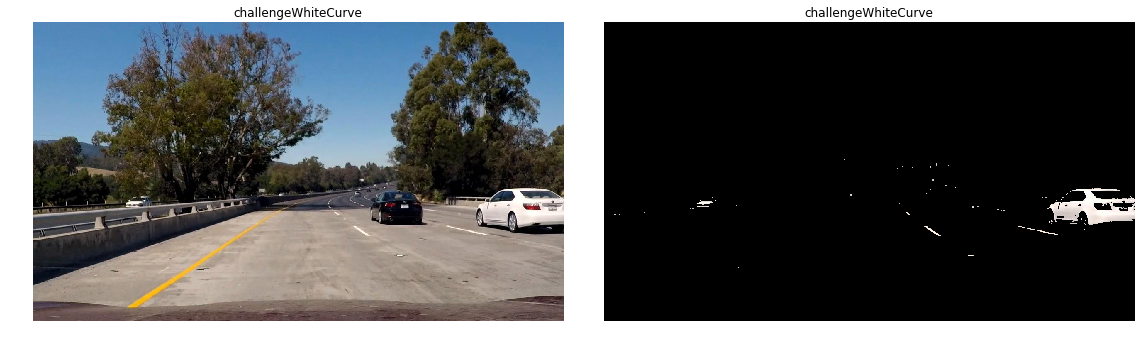

In [97]:
# HSV value range of desired color, i.e. white and yellow
L_COLORS = \
    np.uint8([
        [170, 170, 0],
        [190, 190, 190]
    ])
H_COLORS = \
    np.uint8([
        [255, 255, 150],
        [255, 255, 255]
    ])

imgs = []
for fname in [IMG_FNAMES[1]]:   
    test_fname = "test_images/" + fname
    test_img = mpimg.imread(test_fname)
    finder = \
        LaneFinder(
            test_img,
            low_colors=L_COLORS,
            high_colors=H_COLORS,
            filter_color=True)
    finder.find_lane()
    new_img = finder.masked_color_image
    imgs.extend([test_img, new_img])

# plot image
fig = plt.figure(figsize=(16, 16))
cols = 2
rows = np.ceil(len(imgs)/cols).astype(int)
for i in range(rows):
    for j in range(cols):
        idx = i*cols+j
        fig.add_subplot(rows, cols, idx+1)
        img_name,_ = os.path.splitext(IMG_FNAMES[i])
        plt.title(img_name)
        plt.imshow(imgs[idx])
        plt.axis('off')
plt.tight_layout()
plt.show()

Testing for Gaussian Blurring

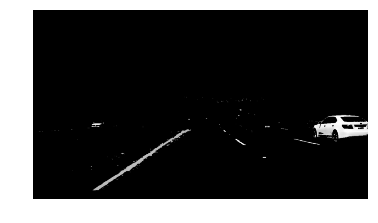

In [92]:
KSIZE = 5

finder = \
    LaneFinder(
        tune_img,
        k_size=KSIZE,
        low_colors=L_COLORS,
        high_colors=H_COLORS,
        filter_color=True)
finder.find_lane()
tmp_img = finder.blur_gray_image
plt.imshow(tmp_img)
plt.axis('off')
plt.show()

Testing for ROI vertices

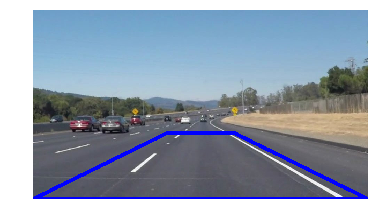

In [64]:
finder = LaneFinder(tune_img)
finder.find_lane()
tmp_img = finder.roi_image
plt.imshow(tmp_img)
plt.axis('off')
plt.show()

Testing for Canny Detection

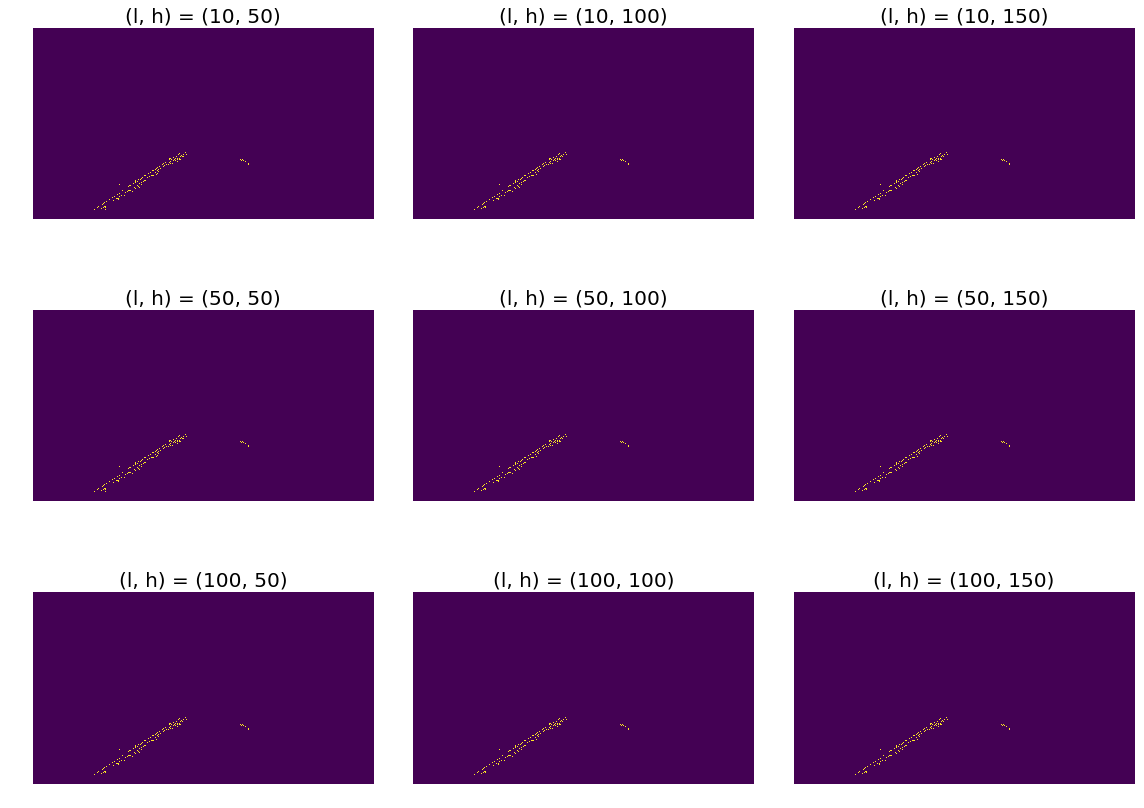

In [93]:
l_params = [10, 50, 100]
h_params = [50, 100, 150]

rows = len(l_params)
cols = len(h_params)

fig = plt.figure(figsize=(16, 12))

img_list = []
for i in range(rows):
    for j in range(cols):
        # Canny detection
        l_th = l_params[i]
        h_th = h_params[j]
        finder = LaneFinder(
            tune_img,
            k_size=KSIZE,
            low_thres=l_th,
            high_thres=h_th,
            low_colors=L_COLORS,
            high_colors=H_COLORS,
            filter_color=True,
            raw_line=True)
        finder.find_lane()
        #tmp_img = finder.edge_image
        tmp_img = finder._roi_edge_img
        img_list.append(tmp_img)

        # add subplot
        idx = i*cols+j
        NUM_COLS = cols
        NUM_ROWS = np.ceil(rows*cols/NUM_COLS).astype(int)
        fig.add_subplot(NUM_ROWS, NUM_COLS, idx+1)
        name = "(l, h) = ({}, {})".format(l_th, h_th)
        plt.title(name, fontsize=20)
        plt.imshow(tmp_img)
        plt.axis('off')
plt.tight_layout()
plt.show()        

Testing for Hough-line transform

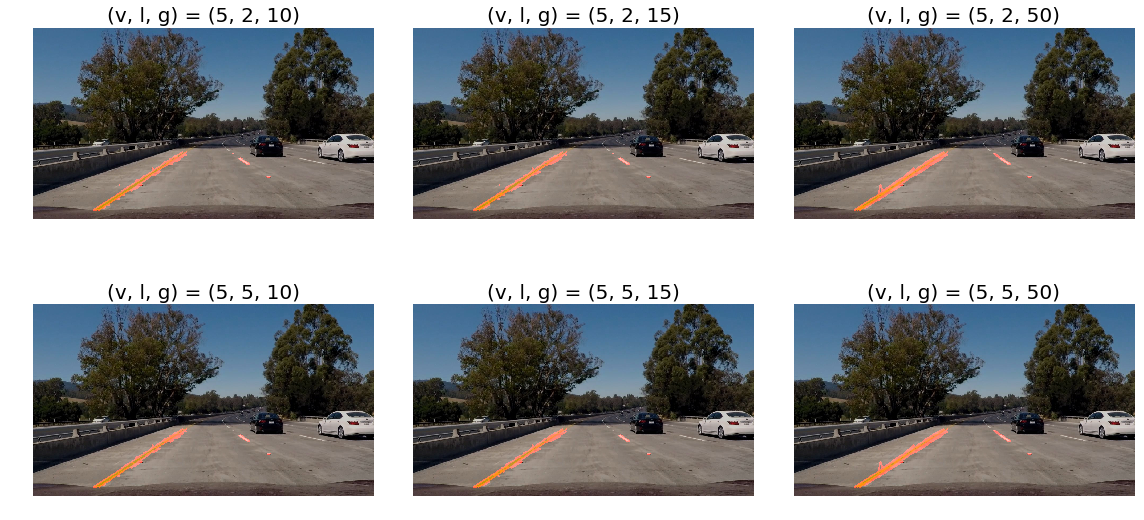

In [95]:
L_THRES = 100
H_THRES = 150

VOTE = 5
len_params = [2, 5]
gap_params = [10, 15, 50]

rows = len(len_params)
cols = len(gap_params)

fig = plt.figure(figsize=(16, 8))

img_list = []
for i in range(rows):
    for j in range(cols):
        # Hough transform
        l = len_params[i]
        gap = gap_params[j]
        finder = LaneFinder(
            tune_img,
            k_size=KSIZE,
            low_thres=L_THRES,
            high_thres=H_THRES,
            min_vote=VOTE,
            min_line_len=l,
            max_line_gap=gap,
            lane_thickness=4,
            m_min=np.tan(np.pi*30/180),
            m_max=np.tan(np.pi*60/180),
            low_colors=L_COLORS,
            high_colors=H_COLORS,
            filter_color=True,
            raw_line=True,
            filter_slope=False,
            polyfit=True)
        finder.find_lane()
        tmp_img = finder.lane_image
        img_list.append(tmp_img)

        # add subplot
        idx = i*cols+j
        NUM_COL = cols
        NUM_ROW = np.ceil(rows*cols/NUM_COL).astype(int)
        fig.add_subplot(NUM_ROW, NUM_COL, idx+1)
        name = "(v, l, g) = ({}, {}, {})".format(VOTE, l, gap)
        plt.title(name, fontsize=20)
        plt.imshow(tmp_img)
        plt.axis('off')
plt.tight_layout()
plt.show()        

## Test on images

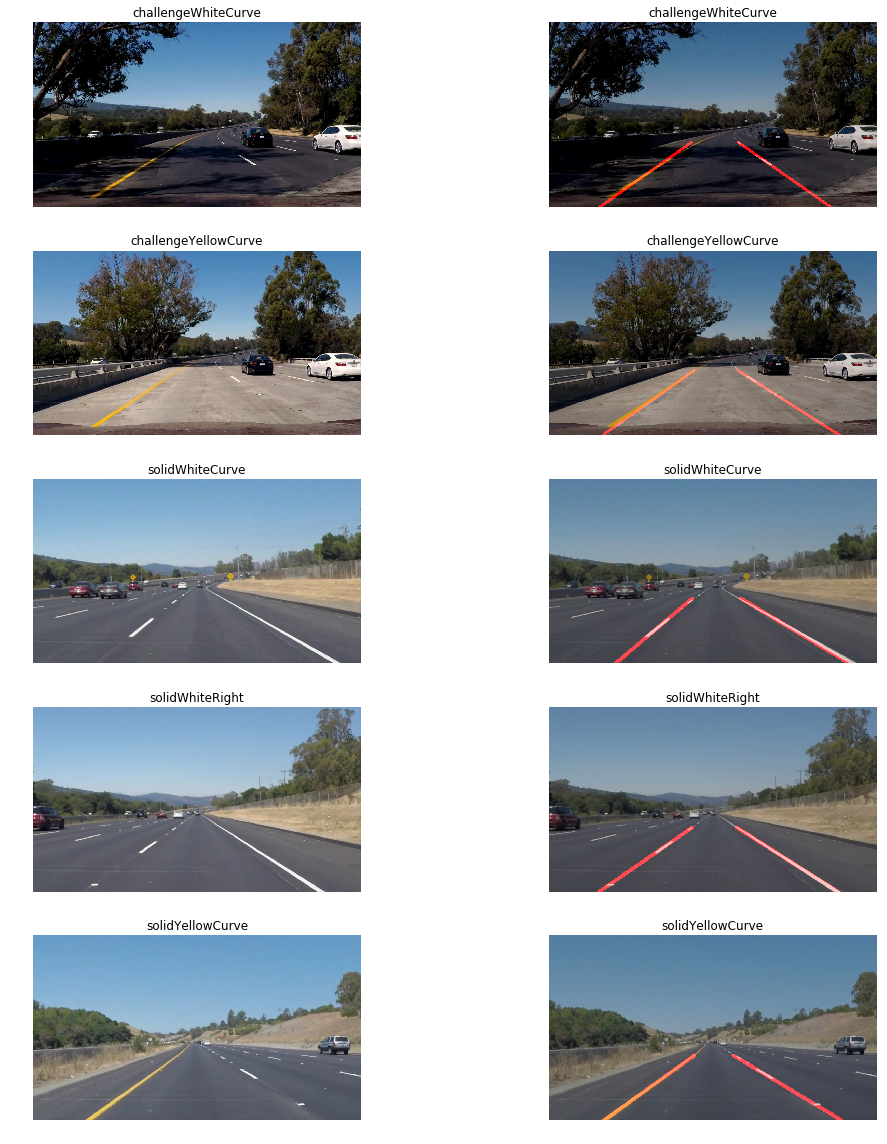

In [76]:
imgs = []
for fname in IMG_FNAMES:   
    test_fname = "test_images/" + fname
    test_img = mpimg.imread(test_fname)
    lane_finder = \
        LaneFinder(
            test_img,
            k_size=KSIZE,
            low_thres=L_THRES,
            high_thres=H_THRES,
            min_vote=VOTE,
            min_line_len=10,
            max_line_gap=10,      
            m_min=np.tan(np.pi*30/180),
            m_max=np.tan(np.pi*60/180),
            low_colors=L_COLORS,
            high_colors=H_COLORS,
            filter_color=True,
            raw_line=False,
            filter_slope=True,
            polyfit=False,
            gray_background=True,
            verbose=False)
    lane_finder.find_lane()
    new_img = lane_finder.lane_image
    #new_img = lane_finder.roi_edge_image
    #new_img = lane_finder.masked_color_image
    imgs.extend([test_img, new_img])

# plot image
fig = plt.figure(figsize=(16, 16))
cols = 2
rows = 5
for i in range(rows):
    for j in range(cols):
        idx = i*cols+j
        fig.add_subplot(rows, cols, idx+1)
        img_name,_ = os.path.splitext(IMG_FNAMES[i])
        plt.title(img_name)
        plt.imshow(imgs[idx])
        plt.axis('off')
plt.tight_layout()
plt.show()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [77]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [81]:
def process_image(image):
    lane_finder = \
        LaneFinder(
            image,
            k_size=KSIZE,
            low_thres=L_THRES,
            high_thres=H_THRES,
            min_vote=VOTE,
            min_line_len=10,
            max_line_gap=10,
            m_min=np.tan(np.pi*30/180),
            m_max=np.tan(np.pi*60/180),
            low_colors=L_COLORS,
            high_colors=H_COLORS,
            filter_color=True,
            raw_line=False,
            filter_slope=True,
            polyfit=False,
            gray_background=False,
            verbose=False)
    lane_finder.find_lane()
    result = lane_finder.lane_image
    #result = lane_finder.roi_edge_image
    #result = lane_finder.masked_color_image
    
    return result

Let's try the one with the solid white lane on the right first ...

In [82]:
# Test videos filename
white_output = 'test_videos_output/solidWhiteRight.mp4'
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
challenge_output = 'test_videos_output/challenge.mp4'

# Read in test videos
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
clip3 = VideoFileClip('test_videos/challenge.mp4')

# Process frame-by-frame
white_clip = clip1.fl_image(process_image)
yellow_clip = clip2.fl_image(process_image)
challenge_clip = clip3.fl_image(process_image)

# Save videos into files
white_clip.write_videofile(white_output, audio=False)
yellow_clip.write_videofile(yellow_output, audio=False)
challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:08<00:00, 29.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:23<00:00, 28.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:17<00:00, 14.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 



In [83]:
HTML("""
<b>{0}</b>
<video width="576" height="324" controls>
  <source src="{0}">
</video>

<b>{1}</b>
<video width="576" height="324" controls>
  <source src="{1}">
</video>

<b>{2}</b>
<video width="576" height="324" controls>
  <source src="{2}">
</video>
""".format(white_output, yellow_output, challenge_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.
